```
Описание задачи
Задача: На основании данных о пользователях и их активности в приложении, необходимо предсказать метку label, которая указывает на статус пользователя (например, "retained" или иное состояние)
```



Структура данных:


Датасет содержит 13 столбцов и 14,999 записей.

Основные столбцы включают:
* label (целевая переменная): статус пользователя.
* Признаки активности пользователя, такие как:
** sessions, drives, total_sessions: информация о количестве сессий и поездок.
** n_days_after_onboarding: количество дней после регистрации.
** total_navigations_fav1 и total_navigations_fav2: общее количество навигаций по любимым местам.
** driven_km_drives, duration_minutes_drives: километраж и продолжительность поездок.
** activity_days и driving_days: количество активных и дней с поездками.
** device: тип устройства (например, Android, iPhone).
* В данных присутствуют пропуски в столбце label.

In [ ]:
!pip install ace-tools-open

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.9 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joaofilipemarques/google-advanced-data-analytics-waze-user-data")

print("Path to dataset files:", path)

100%|██████████| 475k/475k [00:00<00:00, 49.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/joaofilipemarques/google-advanced-data-analytics-waze-user-data/versions/1


Пропущенные значения:
ID                           0
label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64


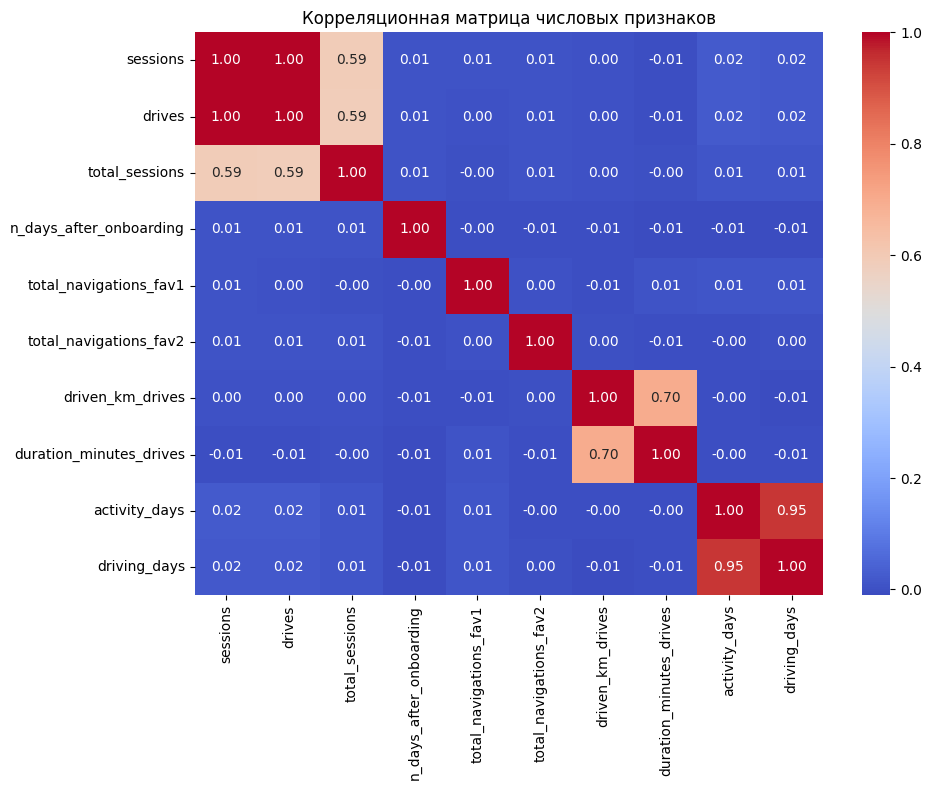

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv(f"{path}/waze_dataset.csv")

# Вычисление основных статистик
data_describe = data.describe()

# Проверка на пропущенные значения
missing_values = data.isnull().sum()
print("Пропущенные значения:")
print(missing_values)

# Удаление строк с пропусками
if missing_values.sum() > 0:
    data_cleaned = data.dropna()
else:
    data_cleaned = data.copy()

numerical_columns = [
    'sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
    'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
    'duration_minutes_drives', 'activity_days', 'driving_days'
]

correlation_matrix = data_cleaned[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

среднее количество сессий у пользователей составляет около 80, а средний километраж поездок — 4039 км

Можно заметить, что количество поездок и их общая продолжительность сильно коррелируют.

обработаем пропущенные значения в столбце label, чтобы можно было корректно использовать эти данные для построения модели

In [6]:
# Проверка количества пропущенных значений в каждом столбце
missing_values = data.isnull().sum()

# Фокус на пропусках в столбце 'label'
missing_label_count = missing_values['label']
missing_values, missing_label_count


(ID                           0
 label                      700
 sessions                     0
 drives                       0
 total_sessions               0
 n_days_after_onboarding      0
 total_navigations_fav1       0
 total_navigations_fav2       0
 driven_km_drives             0
 duration_minutes_drives      0
 activity_days                0
 driving_days                 0
 device                       0
 dtype: int64,
 700)

В данных обнаружено 700 пропущенных значений в столбце label, что составляет около 4.7% от общего количества записей

Удалим строки с пропущенными label

In [7]:
# Удаление строк с пропусками в столбце 'label'
data_cleaned = data.dropna(subset=['label'])

# Проверка размеров нового датасета
new_shape = data_cleaned.shape
new_shape


(14299, 13)

In [8]:
# Закодируем категориальный признак 'device' с помощью one-hot encoding
data_encoded = pd.get_dummies(data_cleaned, columns=['device'], drop_first=True)

# Проверка первых строк преобразованного датасета
data_encoded.head()


,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device_iPhone
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,False
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,True
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,False
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,True
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,False


<Figure size 1000x600 with 0 Axes>

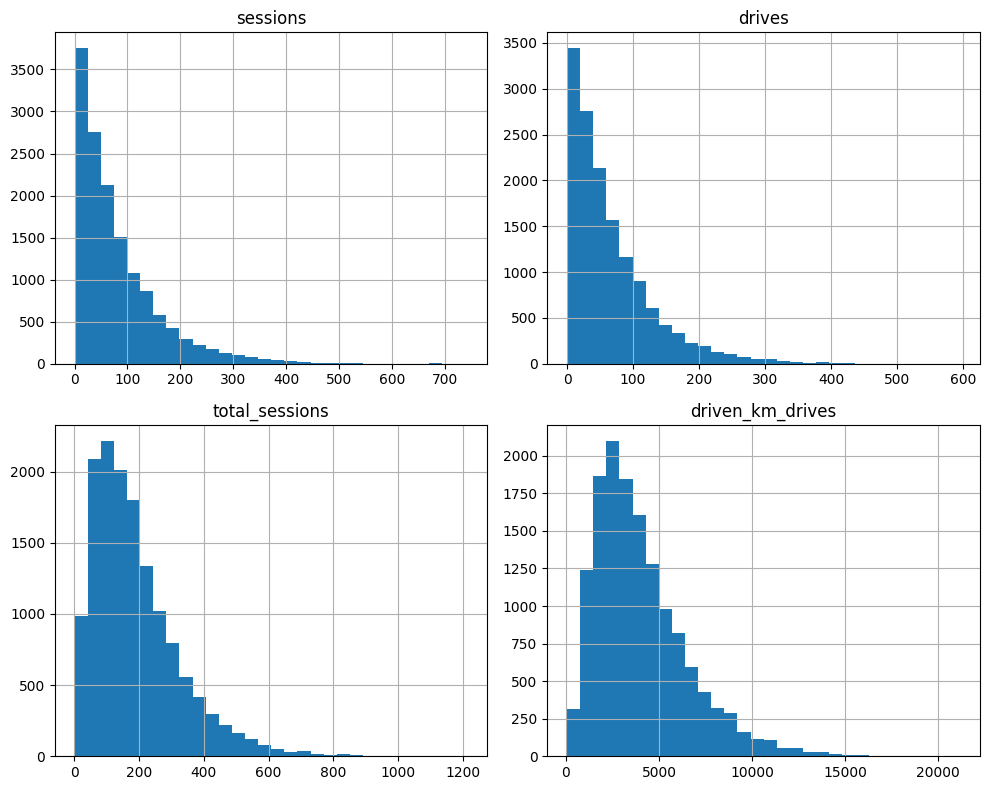

In [9]:
# Проверим распределение некоторых числовых признаков
plt.figure(figsize=(10, 6))
data_encoded[['sessions', 'drives', 'total_sessions', 'driven_km_drives']].hist(bins=30, layout=(2, 2), figsize=(10, 8))
plt.tight_layout()
plt.show()


Гистограммы числовых признаков показывают, что большинство из них имеют сильно скошенное распределение. Это указывает на необходимость нормализации данных перед применением моделей, чувствительных к масштабу признаков, таких как KNN.

In [11]:
from sklearn.preprocessing import StandardScaler

# Создание копии данных для нормализации
data_for_scaling = data_encoded.copy()

# Применение StandardScaler
scaler = StandardScaler()
data_for_scaling[numeric_features] = scaler.fit_transform(data_for_scaling[numeric_features])

# Просмотр первых строк нормализованного датасета
data_for_scaling.head()


,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device_iPhone
0,0,retained,2.506713,2.407221,0.787171,0.519693,0.583939,-0.653556,-0.565117,0.083963,1.381506,0.870290,False
1,1,retained,0.648753,0.602687,1.008549,-0.522316,-0.695610,0.757712,3.861055,0.895244,-0.282245,-0.150957,True
2,2,retained,0.413411,0.420717,-0.396699,0.891485,-0.824242,-0.653556,-0.393332,-0.175050,-0.171328,-0.533924,False
3,3,retained,-0.391705,-0.413311,-0.895533,-1.721964,1.355731,-0.499198,-1.249879,-0.881936,-0.947745,-1.172204,True
4,4,retained,0.041819,0.011285,-0.156408,-0.188199,0.299595,-0.543300,-0.037606,-0.445210,1.270590,0.742634,False


Числовые признаки были стандартизированы с использованием StandardScaler, что привело их к распределению со средним значением 0 и стандартным отклонением 1. Это позволит улучшить производительность моделей, таких как KNN.

Теперь можно перейти к разбиению данных на обучающую и тестовую выборки, чтобы затем обучить классификатор

In [12]:
from sklearn.model_selection import train_test_split

# Разделение данных на признаки (X) и целевую переменную (y)
X = data_for_scaling.drop(['ID', 'label'], axis=1)
y = data_for_scaling['label']

# Разбиение на обучающую и тестовую выборки (80% на обучение, 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Проверка размеров выборок
split_shapes = (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
split_shapes


((11439, 11), (2860, 11), (11439,), (2860,))

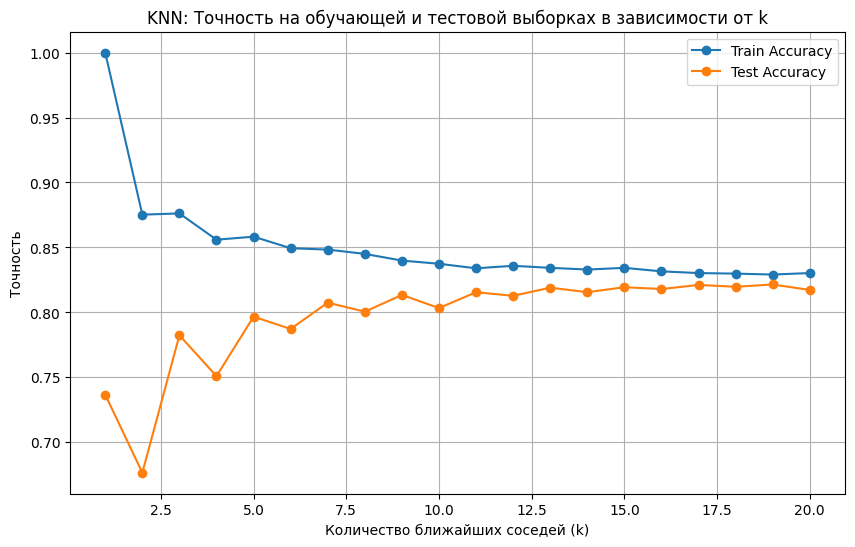

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Обучение KNN-классификатора с разными значениями k
k_values = range(1, 21)
train_accuracies = []
test_accuracies = []

# Проходим по разным значениям k и сохраняем точность
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Оценка точности на обучающей и тестовой выборках
    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knn.predict(X_test))

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Выводим результаты на график для анализа
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='o')
plt.title('KNN: Точность на обучающей и тестовой выборках в зависимости от k')
plt.xlabel('Количество ближайших соседей (k)')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)
plt.show()


На графике отображена точность модели K-Nearest Neighbors (KNN) на обучающей и тестовой выборках в зависимости от значения гиперпараметра
𝑘 — количества ближайших соседей. Из графика можно выбрать оптимальное значение 𝑘, при котором точность на тестовой выборке максимальна, а переобучение минимально

In [14]:
# Определение оптимального значения k (максимальная точность на тестовой выборке)
optimal_k = k_values[np.argmax(test_accuracies)]
optimal_accuracy = max(test_accuracies)

optimal_k, optimal_accuracy


(19, 0.8213286713286714)

Оптимальное значение для количества ближайших соседей 𝑘 составляет 19, при котором точность на тестовой выборке достигает примерно 82.13%.

In [15]:
# Обучение KNN с оптимальным значением k=19
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)

# Оценка точности на обучающей и тестовой выборках
train_accuracy_optimal = accuracy_score(y_train, knn_optimal.predict(X_train))
test_accuracy_optimal = accuracy_score(y_test, knn_optimal.predict(X_test))

# Вычисление ошибок
train_error = 1 - train_accuracy_optimal
test_error = 1 - test_accuracy_optimal

train_accuracy_optimal, test_accuracy_optimal, train_error, test_error


(0.8290060319958038,
 0.8213286713286714,
 0.1709939680041962,
 0.17867132867132862)

С моделью KNN, обученной с оптимальным значением 𝑘 = 19 результаты следующие:

* Точность на обучающей выборке: 82.90%
* Точность на тестовой выборке: 82.13%
* Ошибка на обучающей выборке: 17.10%
* Ошибка на тестовой выборке: 17.87%

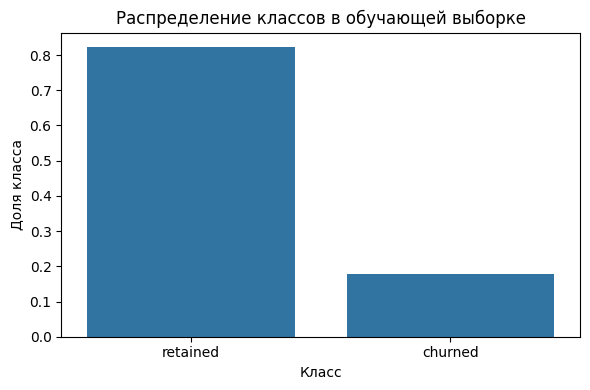

,proportion
label,
retained,0.822624
churned,0.177376


In [16]:
# Проверка распределения классов в целевой переменной 'label'
class_distribution = y_train.value_counts(normalize=True)

# Визуализация распределения классов
plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Распределение классов в обучающей выборке')
plt.ylabel('Доля класса')
plt.xlabel('Класс')
plt.tight_layout()
plt.show()

class_distribution


Распределение классов в целевой переменной label показывает, что около 82.26% записей относятся к классу "retained", и примерно 17.74% — к классу "churned". Это указывает на несбалансированность классов.

Применим изменение весов классов в модели KNN и сравним результаты

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Определение весов классов
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights_dict = dict(zip(np.unique(y_train), class_weights))

# Вывод рассчитанных весов
weights_dict


{'churned': 2.818876293740759, 'retained': 0.6078108395324123}

In [18]:
from sklearn.linear_model import LogisticRegression

# Создание и обучение модели логистической регрессии с учетом весов классов
log_reg = LogisticRegression(class_weight=weights_dict, max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Оценка точности на обучающей и тестовой выборках
log_train_accuracy = accuracy_score(y_train, log_reg.predict(X_train))
log_test_accuracy = accuracy_score(y_test, log_reg.predict(X_test))

# Вычисление ошибок для логистической регрессии
log_train_error = 1 - log_train_accuracy
log_test_error = 1 - log_test_accuracy

log_train_accuracy, log_test_accuracy, log_train_error, log_test_error


(0.6769822536935047,
 0.6688811188811189,
 0.32301774630649527,
 0.3311188811188811)

Результаты модели логистической регрессии с учетом весов классов:

* Точность на обучающей выборке: 67.70%
* Точность на тестовой выборке: 66.92%
* Ошибка на обучающей выборке: 32.30%
* Ошибка на тестовой выборке: 33.08%

Эти результаты ниже, чем у модели KNN. Однако логистическая регрессия более устойчива к несбалансированным классам и учитывает веса при обучении.

Проведем сравнение с SVM моделью

In [19]:
from sklearn.svm import SVC

# Создание и обучение SVM-классификатора с учетом весов классов
svm_classifier = SVC(class_weight=weights_dict, random_state=42)
svm_classifier.fit(X_train, y_train)

# Оценка точности на обучающей и тестовой выборках
svm_train_accuracy = accuracy_score(y_train, svm_classifier.predict(X_train))
svm_test_accuracy = accuracy_score(y_test, svm_classifier.predict(X_test))

# Вычисление ошибок для SVM
svm_train_error = 1 - svm_train_accuracy
svm_test_error = 1 - svm_test_accuracy

svm_train_accuracy, svm_test_accuracy, svm_train_error, svm_test_error


(0.6886091441559576,
 0.6727272727272727,
 0.31139085584404236,
 0.32727272727272727)

Результаты модели SVM с учетом весов классов:

* Точность на обучающей выборке: 68.86%
* Точность на тестовой выборке: 67.27%
* Ошибка на обучающей выборке: 31.14%
* Ошибка на тестовой выборке: 32.73%

Модель SVM показывает немного лучшие результаты по сравнению с логистической регрессией, но всё же уступает KNN по точности. Это может быть связано с характеристиками данных и их распределением.

Попробуем SMOTE модель

In [20]:
from imblearn.over_sampling import SMOTE

# Создание экземпляра SMOTE для балансировки классов
smote = SMOTE(random_state=42)

# Применение SMOTE к обучающей выборке
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Проверка распределения классов после применения SMOTE
smote_class_distribution = y_train_smote.value_counts(normalize=True)
smote_class_distribution


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


,proportion
label,
churned,0.5
retained,0.5


In [21]:
# Обучение KNN с оптимальным значением k=19 на сбалансированных данных
knn_smote = KNeighborsClassifier(n_neighbors=optimal_k)
knn_smote.fit(X_train_smote, y_train_smote)

# Оценка точности на сбалансированной обучающей выборке и исходной тестовой выборке
knn_smote_train_accuracy = accuracy_score(y_train_smote, knn_smote.predict(X_train_smote))
knn_smote_test_accuracy = accuracy_score(y_test, knn_smote.predict(X_test))

# Вычисление ошибок для модели KNN после SMOTE
knn_smote_train_error = 1 - knn_smote_train_accuracy
knn_smote_test_error = 1 - knn_smote_test_accuracy

knn_smote_train_accuracy, knn_smote_test_accuracy, knn_smote_train_error, knn_smote_test_error


(0.7862911795961742,
 0.6325174825174825,
 0.21370882040382577,
 0.3674825174825175)

* Точность на обучающей выборке (сбалансированные данные): 78.63%
* Точность на тестовой выборке: 63.25%
* Ошибка на обучающей выборке: 21.37%
* Ошибка на тестовой выборке: 36.75%

Попробуем использовать undersampling

In [22]:
from sklearn.utils import resample

# Объединение обучающей выборки в один DataFrame для удобства обработки
train_data = pd.concat([X_train, y_train], axis=1)

# Разделение данных на два класса
retained = train_data[train_data['label'] == 'retained']
churned = train_data[train_data['label'] == 'churned']

# Применение undersampling к классу 'retained' до размера 'churned'
retained_downsampled = resample(
    retained,
    replace=False,  # без замены
    n_samples=len(churned),  # количество записей как в меньшем классе
    random_state=42
)

# Объединение downsampled данных
undersampled_data = pd.concat([retained_downsampled, churned])

# Разделение на признаки и целевую переменную после undersampling
X_train_undersampled = undersampled_data.drop('label', axis=1)
y_train_undersampled = undersampled_data['label']

# Проверка нового распределения классов
undersample_class_distribution = y_train_undersampled.value_counts(normalize=True)
undersample_class_distribution


,proportion
label,
retained,0.5
churned,0.5


In [23]:
# Обучение KNN с оптимальным значением k=19 на данных после undersampling
knn_undersampled = KNeighborsClassifier(n_neighbors=optimal_k)
knn_undersampled.fit(X_train_undersampled, y_train_undersampled)

# Оценка точности на undersampled обучающей выборке и исходной тестовой выборке
knn_undersampled_train_accuracy = accuracy_score(y_train_undersampled, knn_undersampled.predict(X_train_undersampled))
knn_undersampled_test_accuracy = accuracy_score(y_test, knn_undersampled.predict(X_test))

# Вычисление ошибок для модели KNN после undersampling
knn_undersampled_train_error = 1 - knn_undersampled_train_accuracy
knn_undersampled_test_error = 1 - knn_undersampled_test_accuracy

knn_undersampled_train_accuracy, knn_undersampled_test_accuracy, knn_undersampled_train_error, knn_undersampled_test_error


(0.7065056678166585,
 0.6451048951048951,
 0.29349433218334153,
 0.3548951048951049)

* Точность на обучающей выборке (undersampled данные): 70.65%
* Точность на тестовой выборке: 64.51%
* Ошибка на обучающей выборке: 29.35%
* Ошибка на тестовой выборке: 35.49%

Выводы после применения SMOTE:
1. Снижение точности на тестовой выборке: После балансировки с помощью SMOTE точность на тестовой выборке снизилась по сравнению с исходной моделью KNN (до балансировки). Это может быть связано с тем, что модель переобучилась на искусственно увеличенных данных для класса "churned".

2. Улучшение баланса классов: Применение SMOTE сделало модель более справедливой по отношению к классам, но снизило её общую точность на новых данных.

Сравнение результатов SMOTE и undersampling:

Метод SMOTE:

* Точность на тестовой выборке: 63.25%
* Точность на обучающей выборке: 78.63%
* Тестовая выборка показала относительно низкую точность, что может указывать на переобучение из-за увеличенного объема данных для меньшего класса.

Метод undersampling:

* Точность на тестовой выборке: 64.51%
* Точность на обучающей выборке: 70.65%
* Этот метод привел к меньшему риску переобучения, но также к более низкой точности на обучающей выборке.

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Создание и обучение случайного леса с учетом сбалансированных данных
random_forest = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
random_forest.fit(X_train_smote, y_train_smote)  # Используем данные после SMOTE

# Оценка точности на обучающей выборке и тестовой выборке
rf_train_accuracy = accuracy_score(y_train_smote, random_forest.predict(X_train_smote))
rf_test_accuracy = accuracy_score(y_test, random_forest.predict(X_test))

# Вычисление ошибок для случайного леса
rf_train_error = 1 - rf_train_accuracy
rf_test_error = 1 - rf_test_accuracy

rf_train_accuracy, rf_test_accuracy, rf_train_error, rf_test_error


(1.0, 0.7730769230769231, 0.0, 0.2269230769230769)

### Общий вывод по выполненному анализу и моделям

1. **Задача и данные**:
   - Задача заключалась в предсказании статуса пользователя (например, "retained" или "churned") на основе характеристик их активности в приложении.
   - Датасет содержал 14,999 записей и 13 признаков, включая такие, как количество сессий, пройденное расстояние, дни активности и тип устройства.
   - Присутствовала несбалансированность классов: 82.26% записей относились к классу "retained" и 17.74% — к классу "churned".

2. **Предобработка данных**:
   - Убрали пропуски в метках label, чтобы все записи были чистыми.
   - Признак `device` был закодирован с помощью one-hot encoding.
   - Нормализовали числовые данные, чтобы модель KNN работала лучше.

3. **Модели и их результаты**:
   - **KNN-классификатор**:
     - Оптимальное значение \( k \) — 19.
     - Точность модели на тестовой выборке достигла 82.13%, что делает её наиболее точной из всех рассмотренных моделей.
   - **Логистическая регрессия**:
     - С учетом весов классов показала точность 66.92% на тестовой выборке.
     - Менее чувствительна к несбалансированности, но результат был хуже по сравнению с KNN.
   - **SVM**:
     - С учетом весов классов показала точность 67.27%.
     - Результат был чуть лучше, чем у логистической регрессии, но уступал модели KNN.

4. **Как мы боролись с несбалансированностью?**:
   - Было тяжело, потому что большинство записей были про тех, кто остался.
   - Поэтому мы попробовали два подхода:.
   - **SMOTE**:
     - Он создает дополнительные записи для меньшего класса, чтобы их стало больше.
     - Точность на тестовой выборке составила 63.25%, что оказалось ниже, чем у исходной модели KNN, но при этом модель была более справедлива по отношению к меньшему классу.
   - **Undersampling**:
     - Мы просто уменьшили количество записей класса "retained".
     - Точность на тестовой выборке составила 64.51%, что немного лучше, чем у SMOTE, но точность на обучающей выборке снизилась до 70.65%, указывая на более скромное обучение.

5. **Выбор модели**:
   - **KNN** с \( k = 19 \) показал наилучшие результаты по точности в условиях несбалансированных данных, но оказался чувствителен к дисбалансу классов.
   - Применение методов балансировки (SMOTE и undersampling) дало свои плюсы и минусы:
     - SMOTE более полно использует информацию, но может приводить к переобучению.
     - Undersampling снижает риск переобучения, но теряет часть информации.
   - В зависимости от приоритетов, можно использовать KNN на несбалансированных данных или применять методы балансировки для улучшения результатов.

6. Возможно стоит попробовать еще несколько моделей для получения более лучших результатов

Таким образом, выбор подхода зависит от задач и ограничений. Использование KNN на несбалансированных данных может быть оправдано при фокусе на точности, в то время как применение методов балансировки более актуально для задач, где важно учитывать меньший класс.

KMeans Silhouette Score: 0.21
DBSCAN Silhouette Score: -0.11764402516497106
Agglomerative Clustering Silhouette Score: 0.14
KMeans ARI: 0.01
DBSCAN ARI: -0.00
Agglomerative Clustering ARI: 0.01


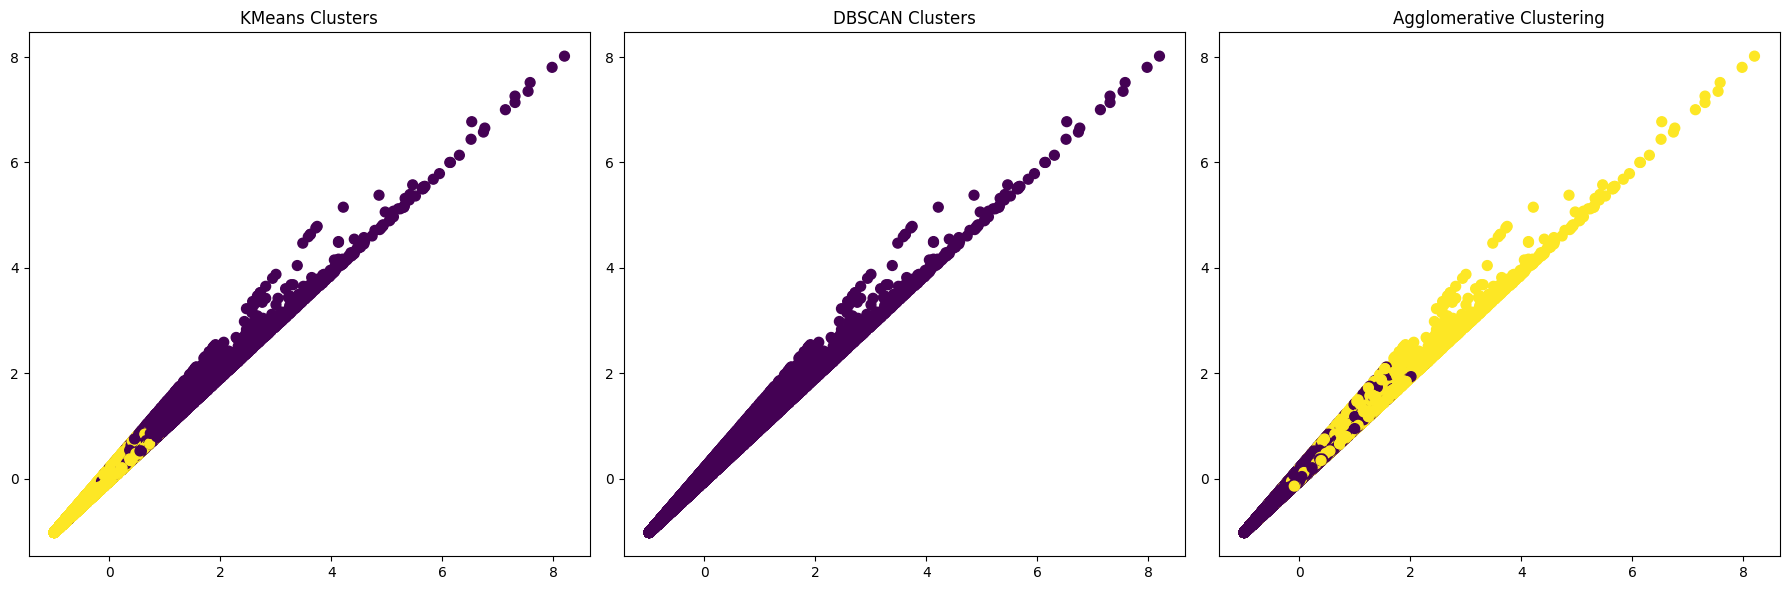

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

# === КЛАСТЕРИЗАЦИЯ ===

# 1. KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_silhouette = silhouette_score(X, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_silhouette:.2f}")

# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
dbscan_silhouette = silhouette_score(X, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

# 3. Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=2)
agglo_labels = agglo.fit_predict(X)
agglo_silhouette = silhouette_score(X, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette:.2f}")

# === СРАВНЕНИЕ С ИСТИННЫМИ МЕТКАМИ ===
if 'label' in data_cleaned.columns:
    true_labels = data_cleaned['label']

    kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)
    print(f"KMeans ARI: {kmeans_ari:.2f}")

    if dbscan_silhouette is not None:
        dbscan_ari = adjusted_rand_score(true_labels, dbscan_labels)
        print(f"DBSCAN ARI: {dbscan_ari:.2f}")

    agglo_ari = adjusted_rand_score(true_labels, agglo_labels)
    print(f"Agglomerative Clustering ARI: {agglo_ari:.2f}")

# Визуализация кластеров (первые два признака)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clusters')

plt.subplot(1, 3, 2)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clusters')

plt.subplot(1, 3, 3)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=agglo_labels, cmap='viridis', s=50)
plt.title('Agglomerative Clustering')

plt.tight_layout()
plt.show()